### 1. Описание набора данных

Набобор даных ```Fashion-MNIST``` содержит изображений одежды из каталога товаров компании Zalando.

### 2. Импорт библиотек

In [1]:
import logging
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import plotly.express as px
import urllib.request
import warnings

from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score

In [2]:
warnings.filterwarnings('ignore')
logging.getLogger('matplotlib').setLevel(logging.ERROR)

### 3. Определение функций

In [3]:
def plot_data_multy(ax, ds, name=''):
  X, y = ds

  ax.set_title(name)

  for i in range(X.shape[0]):
    plt.text(X[i, 0], X[i, 1], str(y[i]),
      color=plt.cm.tab10((y[i]+0.5) /10 ),
      fontdict={'weight': 'bold', 'size': 9}
    )

  x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
  y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5

  ax.set_xlim(x_min, x_max)
  ax.set_ylim(y_min, y_max)
  ax.set_xticks(())
  ax.set_yticks(())

In [4]:
def plot_clustering(X, hc, title, ax=None):
  labels = hc.fit_predict(X)
  if ax is None:
    ax = plt.subplot(1, 1, 1)

  ax.scatter(
    X[:, 0],
    X[:, 1],
    c=labels,
    alpha=0.75,
    cmap='bwr',
    edgecolor='k',
    s=100
  )

  plt.xticks([],[])
  plt.yticks([],[])
  ax.set_title(title)

In [5]:
def plot_dendrogram(model, write_split, **kwargs):
  counts = np.zeros(model.children_.shape[0])
  n_samples = len(model.labels_)
  for i, merge in enumerate(model.children_):
    current_count = 0
    for child_idx in merge:
      if child_idx < n_samples:
        current_count += 1
      else:
        current_count += counts[child_idx - n_samples]
    counts[i] = current_count

  linkage_matrix = np.column_stack([model.children_, model.distances_, counts]).astype(float)
  ddata = dendrogram(linkage_matrix, **kwargs)

  plt.title('Дендрограмма иерархической кластеризации')
  plt.xlabel('индекс образца или (размер кластера)')
  plt.ylabel('расстояние')

  for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
    x = 0.5 * sum(i[1:3])
    y = d[1]
    if y > write_split:
      plt.plot(x, y, 'o', c=c)
      plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
        textcoords='offset points',
        va='top',
        ha='center'
      )

### 4. Создание каталога и скачивание данных

In [6]:
if not os.path.exists('data'):
  os.makedirs('data')

if not os.path.exists('data/fashion_mnist.zip'):
  urllib.request.urlretrieve('https://raw.githubusercontent.com/Losyash/mbml_II_hw/refs/heads/main/lab2/data/fashion_mnist.zip', 'data/fashion_mnist.zip')

### 5. Загрузка набора данных из файла

In [7]:
df = pd.read_csv('data/fashion_mnist.zip')
df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 6. Предобработка данных

#### 6.1. Разделение набора данных на набор с признаками и целевой переменной

In [8]:
X, y = df.drop('label', axis=1), df['label']

#### 6.2. Нормализация данных

In [9]:
X = X / 255.

#### 6.3. Выбор первых 1000 изображений и соответствующих им меток классов

In [10]:
X_part, y_part = X.values[:2500], y[:2500].astype(int).values

### 7. Использование метод снижения размерности и визуализации данных t-SNE

#### 7.1. Определение списка классов

In [11]:
class_labels = {
  0: 'Футболка/топ',
  1: 'Брюки',
  2: 'Пуловер',
  3: 'Платье',
  4: 'Пальто',
  5: 'Сандалия',
  6: 'Рубашка',
  7: 'Кроссовки',
  8: 'Сумка',
  9: 'Ботильоны'
}

#### 7.2. Использование метода t-SNE с разным значением параметра perplexity

In [12]:
n_iter = 5000
perplexity = 10

tsne_10 = TSNE(
  n_components=2,
  verbose=0, 
  perplexity=perplexity,
  n_iter=n_iter,
  learning_rate='auto',
  init='pca'
)

tsne_10_results = tsne_10.fit_transform(X_part)

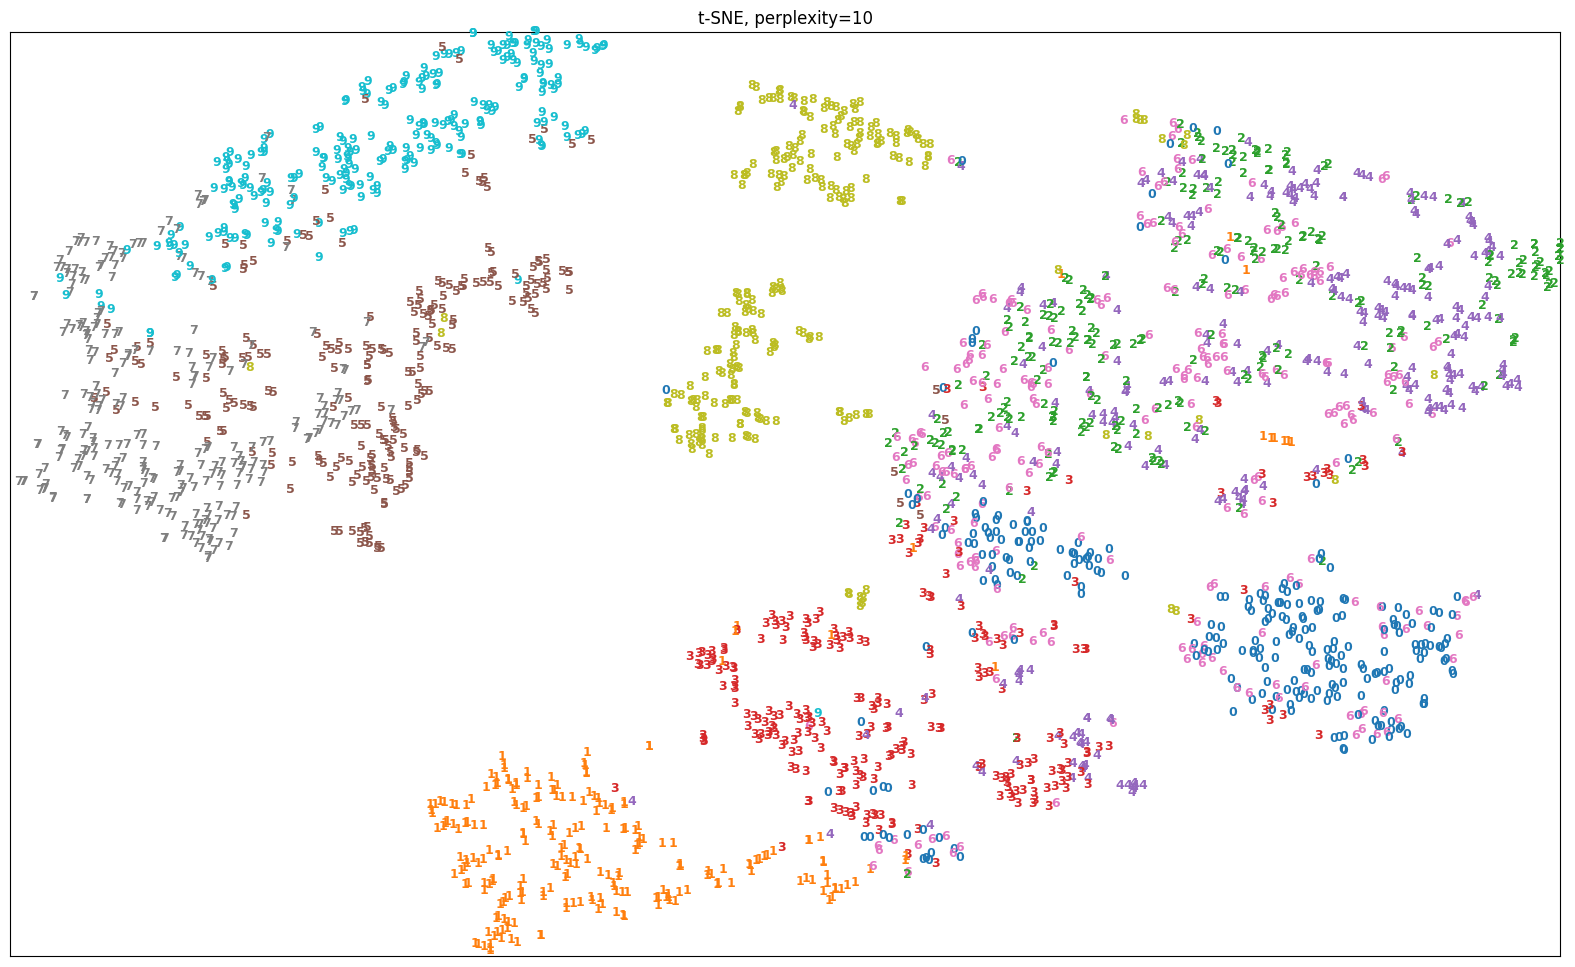

In [13]:
fig = plt.figure(figsize=(20, 12))
ax = plt.subplot(1, 1, 1)
plot_data_multy(ax, [tsne_10_results, y_part], 't-SNE, perplexity=10')

In [14]:
n_iter = 5000
perplexity = 30

tsne_30 = TSNE(
  n_components=2,
  verbose=0, 
  perplexity=perplexity,
  n_iter=n_iter,
  learning_rate='auto',
  init='pca'
)

tsne_30_results = tsne_30.fit_transform(X_part)

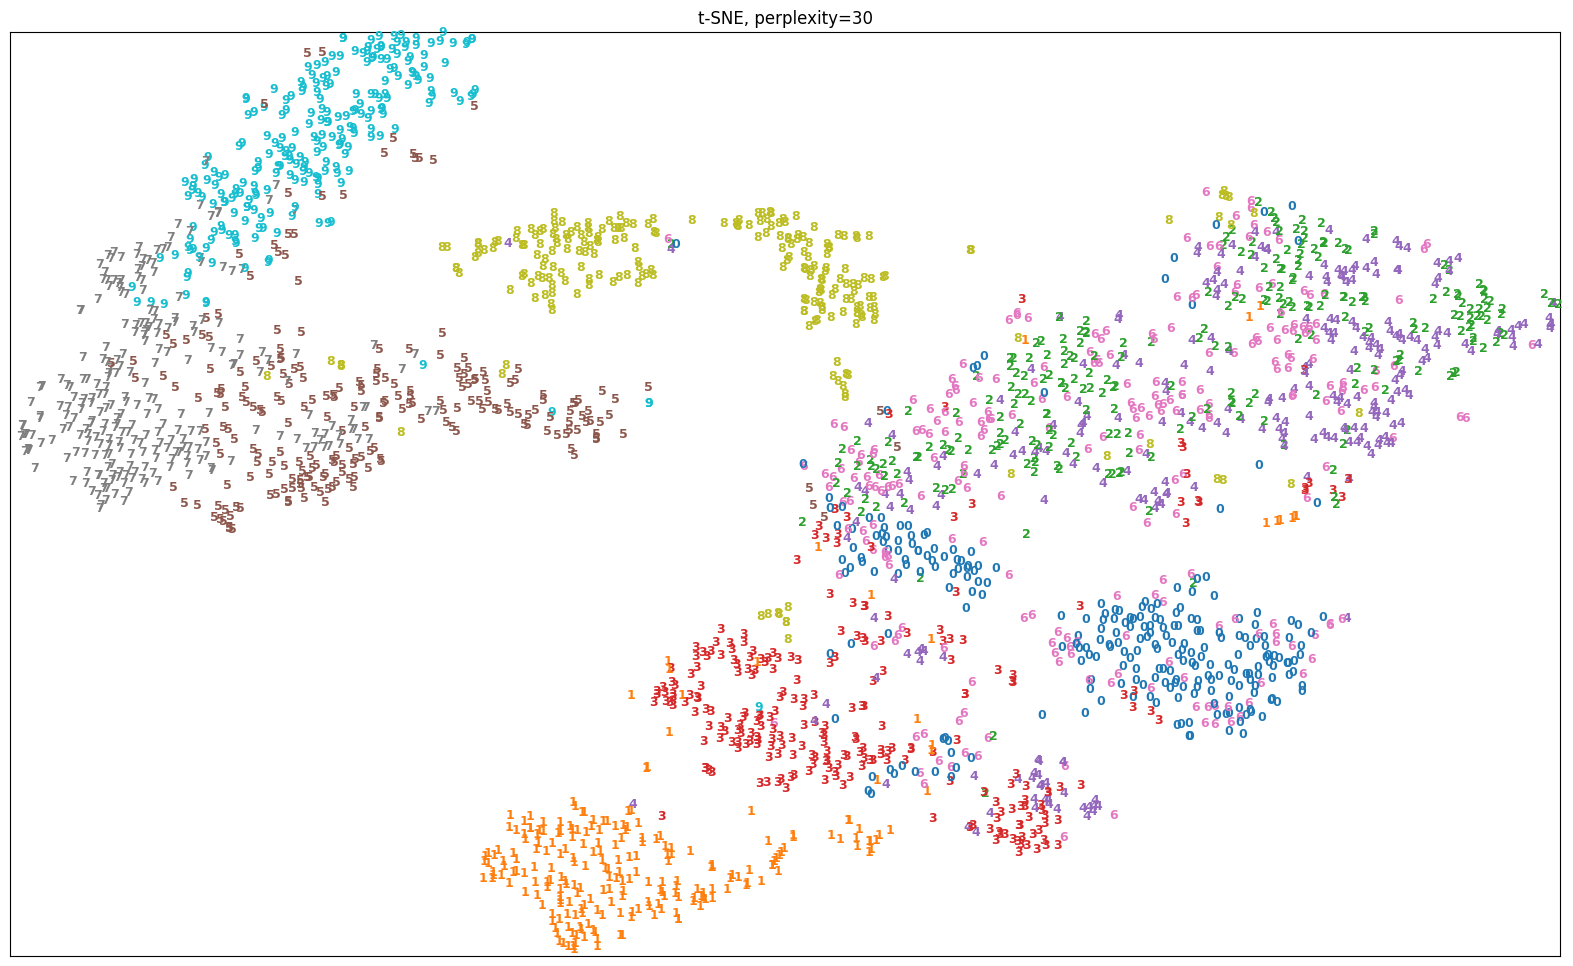

In [15]:
fig = plt.figure(figsize=(20, 12))
ax = plt.subplot(1, 1, 1)
plot_data_multy(ax, [tsne_30_results, y_part], 't-SNE, perplexity=30')

In [16]:
n_iter = 5000
perplexity = 50

tsne_50 = TSNE(
  n_components=2,
  verbose=0, 
  perplexity=perplexity,
  n_iter=n_iter,
  learning_rate='auto',
  init='pca'
)

tsne_50_results = tsne_50.fit_transform(X_part)

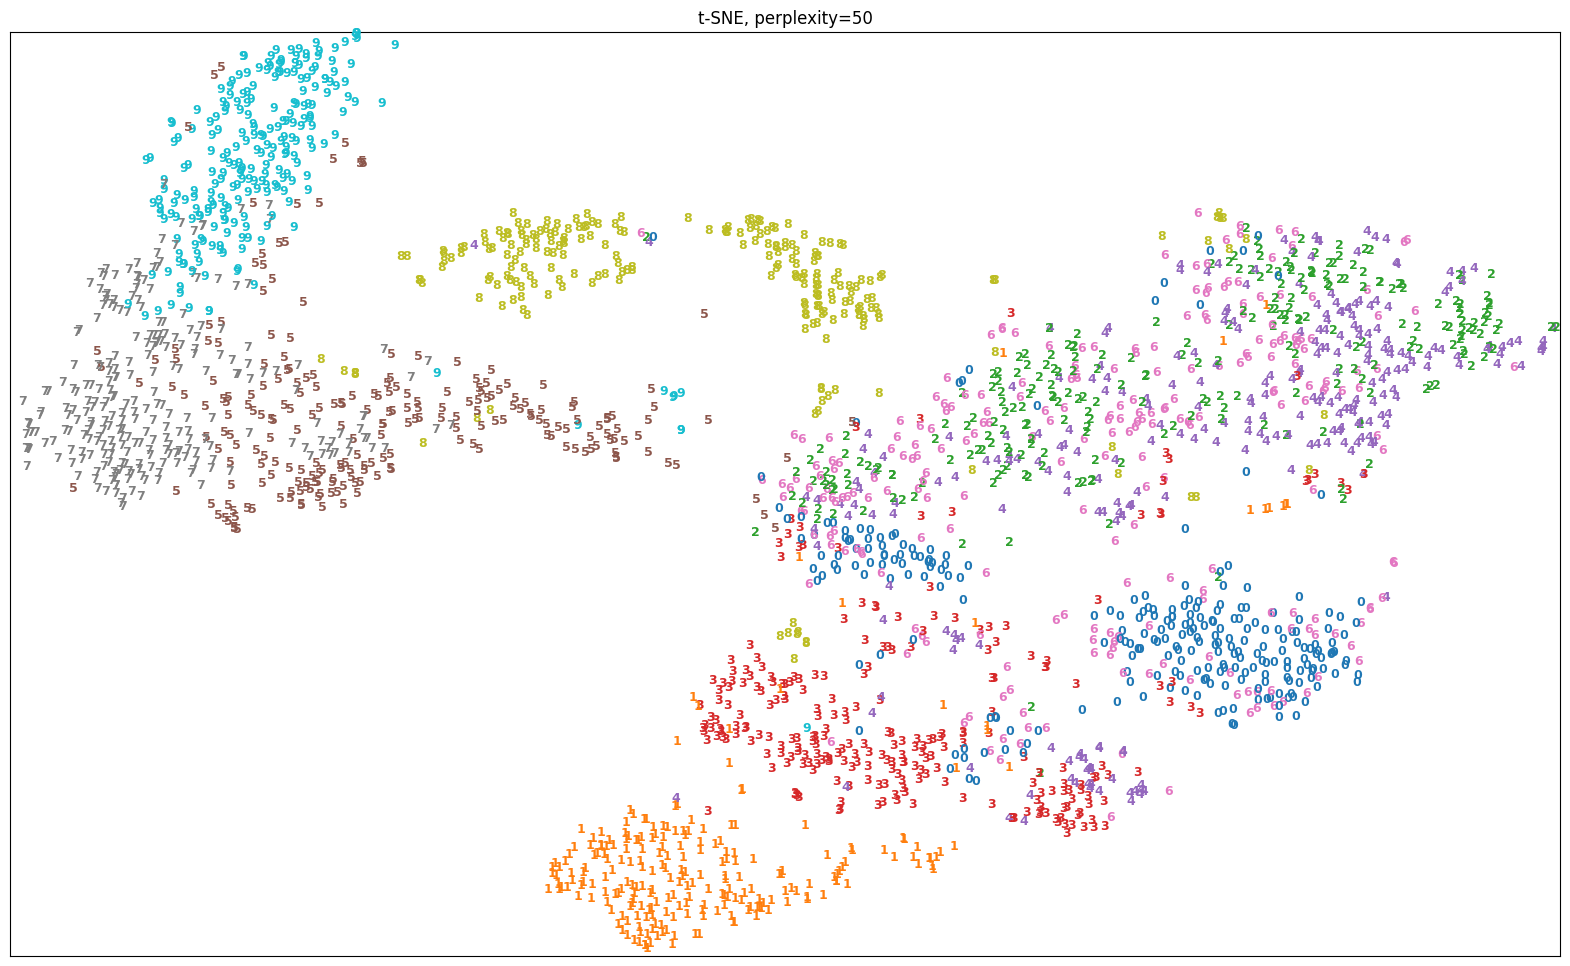

In [17]:
fig = plt.figure(figsize=(20, 12))
ax = plt.subplot(1, 1, 1)
plot_data_multy(ax, [tsne_50_results, y_part], 't-SNE, perplexity=50')

#### 7.3. Выводы по результатам использования метода t-SNE

1. При ```perplexity``` равным 10:
- кластер ```0 (футболки)``` разделен на два отдельных кластера;
- хорошо выделяется кластер ```1 (брюки)```;
- кластеры ```2 (пуловеры)```, ```4 (пальто)```, ```6 (рубашки)``` представляют собой единый кластер;
- неплохо выделяется кластер ```3 (платья)```;
- кластеры ```5 (сандали)```, ```7 (кроссовки)```, ```9 (ботильоны)``` в целом различины, хотя и немного перемешаны;
- достаточно хорошо выделяется кластер ```8 (сумки)```, хотя есть небольшая группа близкая к кластеру ```3 (платья)```.

2. При ```perplexity``` равным 30:
- кластер ```0 (футболки)``` разделен на два отдельных кластера;
- хорошо выделяется кластер ```1 (брюки)```;
- кластеры ```2 (пуловеры)```, ```4 (пальто)```, ```6 (рубашки)`` представляет собой единый смешанный кластер;
- немного лучше стал выделяться кластер ```3 (платья)```;
- немного лучше стали клстеры ```5 (сандали)```, ```7 (кроссовки)```, ```9 (ботильоны)```;
- cитуация с кластером ```8 (сумки)``` практически не изменилась.

2. При ```perplexity``` равным 50:
- отсутствуют существенные видимые изменения.

### 8. Интерактивная визуализации

#### 8.1. Создание набора данных для визуализации

In [18]:
df = pd.DataFrame(tsne_50_results, columns=['t-SNE_1', 't-SNE_2'])
df['number'] = y_part.astype(str)

#### 8.2. Вывод интерактивной визуализации

In [19]:
fig = px.scatter( 
  df,
  x='t-SNE_1', y='t-SNE_2',
  color = 'number',
  labels={'color': 'number'},
  hover_data=[df.index]
)

fig.update_layout(
  height=800,
  width=1400,
  template = "plotly_dark"
)

fig.update_traces(textposition='top center')
fig.show()

#### 8.3. Вывод отдельных ошибочно классифицированных изображений

In [20]:
shady_figs = [ 170, 218, 347, 1519, 2244 ]

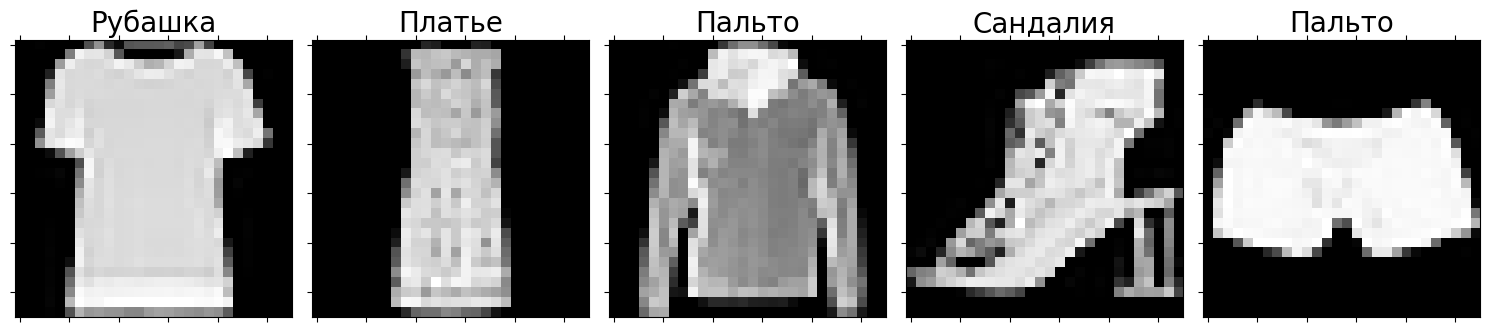

In [21]:
fig = plt.figure(figsize=(15, 8))

for n, i in enumerate(shady_figs):
  ax = fig.add_subplot(2, 5, n+1)
  ax.set_title(class_labels[int(y[i])], size=20)

  ax.matshow(1 - X.loc[i,'pixel1':'pixel784'].values.reshape((28, 28)).astype(float), cmap='Greys')

  plt.setp(ax.get_xticklabels(), visible=False)
  plt.setp(ax.get_yticklabels(), visible=False)
  plt.tight_layout()

### 9. Иерархическая кластеризация

Для ```иерархической кластеризации```: 
- ```linkage``` - тип связей (варианты  `'ward'`, `'average'`, `'complete'`, `'single'`);
- ```n_clusters``` - потенциальное число кластеров;
- ```distance_threshold``` - порог по расстоянию (т. к. `n_clusters` задан, то указываем `None`);
- ```compute_distances=True``` - параметр позволяет вычислять расстояния между кластерами в случае если не используется порог по расстоянию.

#### 9.1. Создание эксземпляров и обучение иерархических классификаторов

In [22]:
hierarchical_classifier_ward = AgglomerativeClustering(
  distance_threshold=None,
  compute_distances=True,
  n_clusters=10,
  linkage='ward'
)

hierarchical_classifier_ward.fit(tsne_50_results)


hierarchical_classifier_average = AgglomerativeClustering(
  distance_threshold=None,
  compute_distances=True,
  n_clusters=10,
  linkage='average'
)

hierarchical_classifier_average.fit(tsne_50_results)


hierarchical_classifier_complete = AgglomerativeClustering(
  distance_threshold=None,
  compute_distances=True,
  n_clusters=10,
  linkage='complete'
)

hierarchical_classifier_complete.fit(tsne_50_results)


hierarchical_classifier_single = AgglomerativeClustering(
  distance_threshold=None,
  n_clusters=10,
  linkage='single'
)

hierarchical_classifier_single.fit(tsne_50_results);

#### 9.2. Визуализации результатов кластеризации

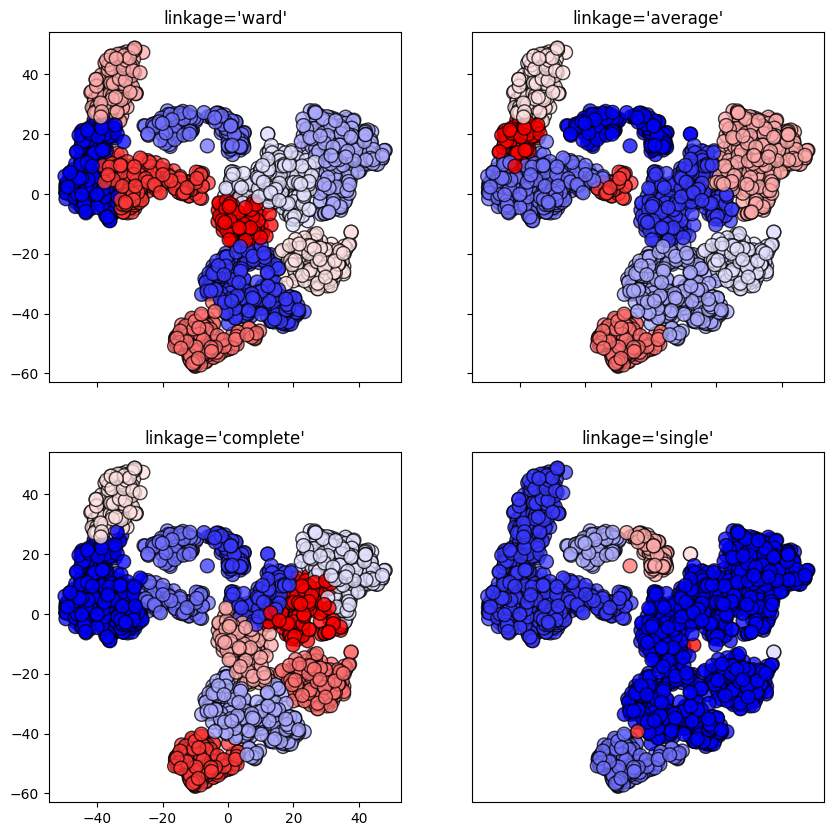

In [23]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

plot_clustering(
  tsne_50_results,
  hierarchical_classifier_ward,
  ax=axs[0, 0],
  title="linkage='ward'"
)

plot_clustering(
  tsne_50_results,
  hierarchical_classifier_average,
  ax=axs[0, 1],
  title="linkage='average'"
)

plot_clustering(
  tsne_50_results,
  hierarchical_classifier_complete,
  ax=axs[1, 0],
  title="linkage='complete'"
)

plot_clustering(
  tsne_50_results,
  hierarchical_classifier_single,
  ax=axs[1, 1],
  title="linkage='single'"
)

for ax in axs.flat:
  ax.label_outer()

plt.show()

#### 9.3. Отрисовка дендрограммы

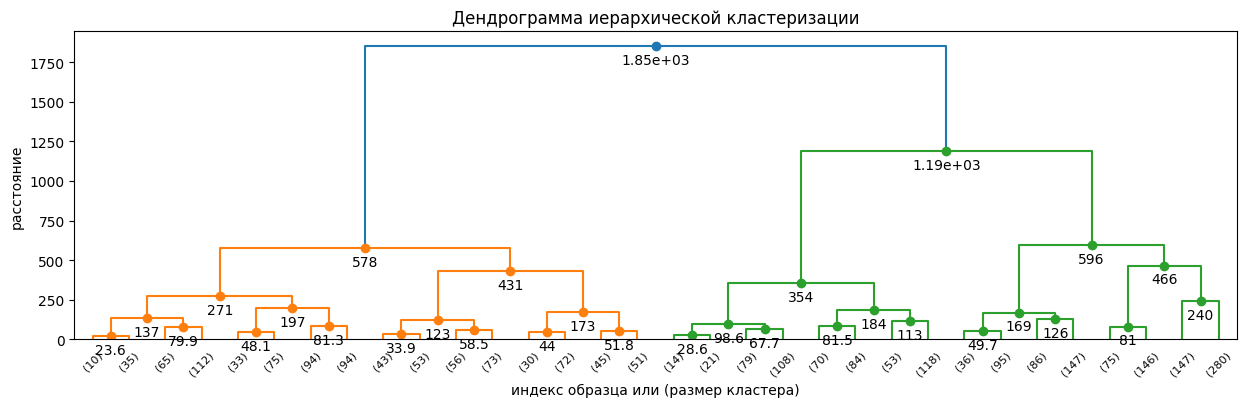

In [24]:
plt.figure(figsize=(15,4))
plot_dendrogram(hierarchical_classifier_ward, write_split=1, truncate_mode='level', p=4)

### 9.4. Примнение дендрограмма для кластеризации с использованием порога по расстоянию

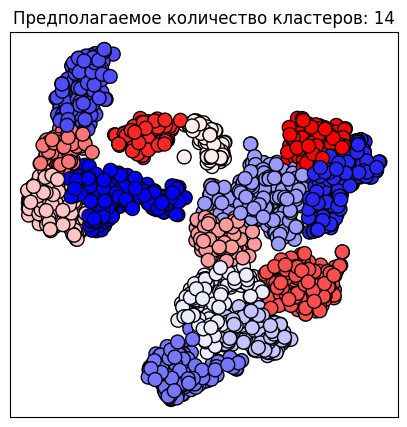

In [ ]:
#@title Задание distance_threshold { run: "auto" }
#@markdown Можно писать число
distance_threshold = 140 #@param {type:"number"}

hierarchical_classifier = AgglomerativeClustering(
  distance_threshold=distance_threshold,
  n_clusters=None,
  linkage='ward'
)

hierarchical_classifier = hierarchical_classifier.fit(tsne_50_results)
n_clusters_ = hierarchical_classifier.n_clusters_

labels = hierarchical_classifier.fit_predict(tsne_50_results)

plt.figure(figsize=(5, 5))
plt.scatter(tsne_50_results[:, 0], tsne_50_results[:, 1], cmap='bwr', c=labels, edgecolors='k', s=100)
plt.title('Предполагаемое количество кластеров: %d' % n_clusters_)
plt.xticks([],[])
plt.yticks([],[])
plt.grid()

#### 9.5. Выводы по результатам иерархической кластеризации

- ```иерархическая кластеризация``` один из наиболее подходящим выбором для кластеризации набора данных Fashion-MNIST, так как она позволяет визуализировать структуру данных и выбрать оптимальное количество кластеров;
- методу t-SNE больше соответствует иерархическая кластеризация с ```linkage``` равным ```ward``` и ```average```.

### 11. Использование коэффициента силуэта кластера

In [26]:
labels = hierarchical_classifier_ward.fit_predict(tsne_50_results)
silhouette = silhouette_score(tsne_50_results, labels)

print(f'Среднее значение критерия Силуэта: {silhouette}')

Среднее значение критерия Силуэта: 0.44279056787490845


### 10. Выводы

- метод ```t-SNE``` корректно выделил 7 отдельных кластеров данных из 10;
- деление на 7 кластеров является оптимальным при кластеризации с использованием порога по расстоянию;
- коэффициенты силуэта, равный ```0,456```, показывает среднюю степень сходства, что означает некоторую степень разделения на кластеров при наличии областей пересечения.